In [69]:
import random

from sklearn.metrics import mean_squared_error
# Imports 
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.python.ops.gen_nn_ops import LeakyRelu


In [73]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


def check_stationarity(series):
    adf_result = adfuller(series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def window_generator(data, feature_columns, target_column, input_size, output_size, stride):

    X = []
    y = []

    data = data.sort_index()

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(data[feature_columns])
    scaled_target = target_scaler.fit_transform(data[target_column])

    for start in range(0, len(data) - input_size - output_size + 1, stride):
        end_input = start + input_size
        end_output = end_input + output_size

        X.append(scaled_features[start:end_input])
        y.append(scaled_target[end_input:end_output])

    return np.array(X), np.array(y), feature_scaler, target_scaler


In [19]:
with open("tickers.txt", "r") as file:
    tickers = [line.strip() for line in file]

output_file = "sp500_data.csv"
with open(output_file, "w") as f:
    f.write("Ticker,Date, Volume,Price_Change\n")

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        stock = yf.Ticker(ticker)
        index = stock.history(start="2010-01-01", end="2020-01-01")

        if index.empty:
            print(f"No data for {ticker}. Skipping...")
            continue

        expected_days = 252 * 9  # 10 years of trading data
        if len(index) < expected_days:
            print(f"Incomplete data for {ticker} ({len(index)} days). Skipping...")
            continue

        index['Price_Change'] = index['Close'].pct_change()

        index.reset_index(inplace=True)
        index['Ticker'] = ticker
        index[['Ticker', 'Date', 'Volume', 'Price_Change']].to_csv(
            output_file, mode='a', header=False, index=False
        )

    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
print(f"Data collection complete! Saved to {output_file}.")

Fetching data for EQIX...
Fetching data for STLD...
Fetching data for GPC...
Fetching data for BKNG...
Fetching data for CSX...
Fetching data for AON...
Fetching data for BLK...
Fetching data for TJX...
Fetching data for IRM...
Fetching data for ELV...
Fetching data for ANET...
Incomplete data for ANET (1403 days). Skipping...
Fetching data for LVS...
Fetching data for PCG...
Fetching data for FAST...
Fetching data for GLW...
Fetching data for CNC...
Fetching data for TPR...
Fetching data for CL...
Fetching data for PWR...
Fetching data for FDX...
Fetching data for ROST...
Fetching data for WDC...
Fetching data for V...
Fetching data for AMD...
Fetching data for PM...
Fetching data for NVR...
Fetching data for J...
Fetching data for KDP...
Fetching data for TSLA...
Fetching data for PHM...
Fetching data for HD...
Fetching data for KEYS...
Incomplete data for KEYS (1309 days). Skipping...
Fetching data for LW...
Incomplete data for LW (789 days). Skipping...
Fetching data for RCL...
Fet

In [79]:
clean_data = pd.read_csv("sp500_data.csv")
print(clean_data.shape)
missing_summary = clean_data.isnull().sum()
print(missing_summary[missing_summary > 0])

# Get unique tickers from the 'Ticker' column
unique_tickers = clean_data['Ticker'].unique()

# Count the number of unique tickers
print(f"Number of unique tickers: {len(unique_tickers)}")

#X = clean_data.drop(columns=['Price_Change'])
#y = clean_data['Price_Change']
#print(X.shape, y.shape)
#print(X.head())
#print(y.head())

(1108610, 4)
Price_Change    441
dtype: int64
Number of unique tickers: 441


In [21]:

# Download data
data = yf.download("^GSPC", start="2010-01-01", end="2020-01-01")

# Select relevant columns
index_data = data[["Volume", "Close"]]

# Calculate Price Change
index_data['Price_Change'] = index_data['Close'].pct_change()

# Reset the MultiIndex columns
index_data.columns = ['Volume', 'Close', 'Price_Change']

# Check for rows with NaN values
print("Rows with NaN values:")
print(index_data[index_data.isna().any(axis=1)])

# Drop rows with NaN values
index_data = index_data.dropna(how='any')  # Drops rows where any column has NaN

# Save cleaned data to CSV
index_data.to_csv("sp500_index_volume.csv", mode='w', header=True, index=True)

# Display the cleaned data
print("Cleaned Data:")
print(index_data.head())

[*********************100%***********************]  1 of 1 completed

Rows with NaN values:
                Volume       Close  Price_Change
Date                                            
2010-01-04  3991400000  1132.98999           NaN
Cleaned Data:
                Volume        Close  Price_Change
Date                                             
2010-01-05  2491020000  1136.520020      0.003116
2010-01-06  4972660000  1137.140015      0.000546
2010-01-07  5270680000  1141.689941      0.004001
2010-01-08  4389590000  1144.979980      0.002882
2010-01-11  4255780000  1146.979980      0.001747



/var/folders/0p/n71jz5_54ns2wr18_8vqx9040000gn/T/ipykernel_29619/315180136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['Price_Change'] = index_data['Close'].pct_change()


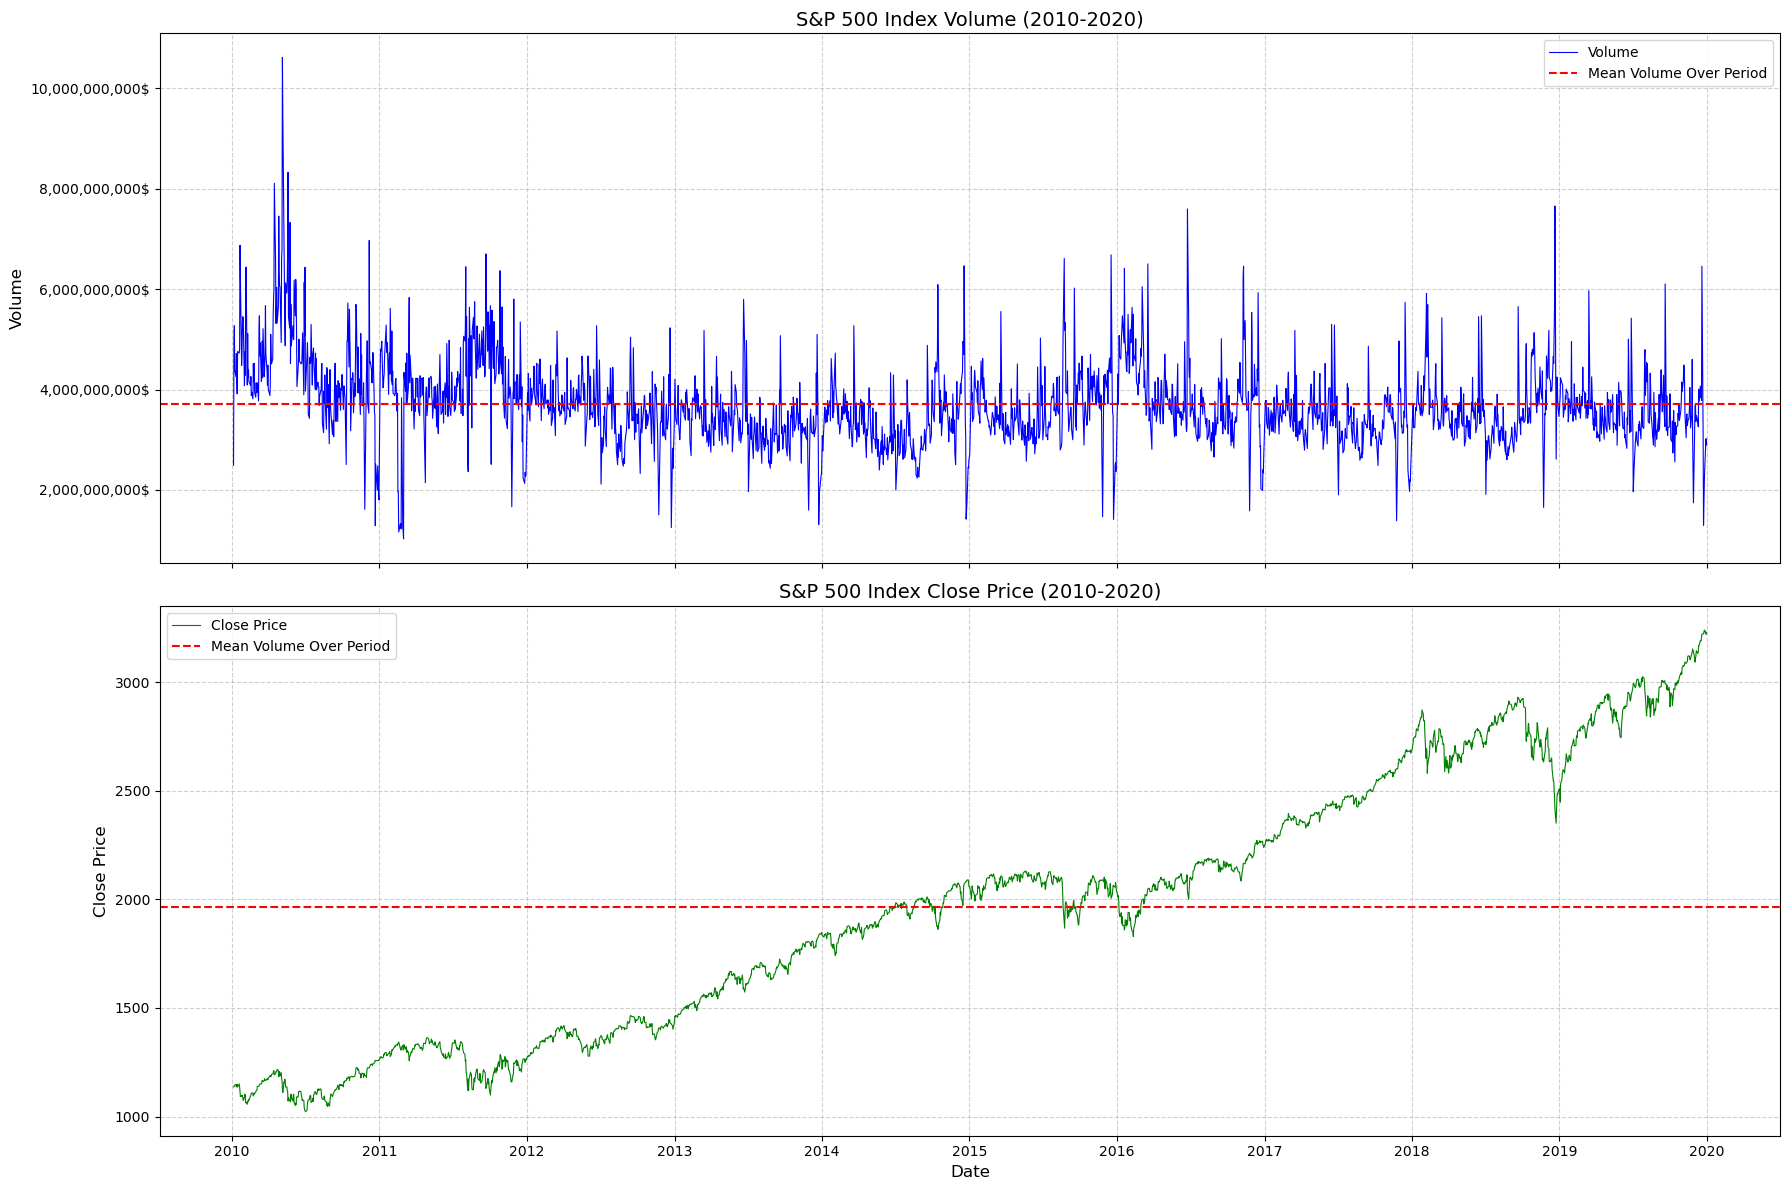

In [22]:
from matplotlib.ticker import FuncFormatter


def format_large_values(x, pos):
    return f'{int(x):,}$'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

ax1.plot(index_data.index, index_data['Volume'].values, label="Volume", linewidth=0.8, color='blue')
ax1.set_title("S&P 500 Index Volume (2010-2020)", fontsize=14)
ax1.set_ylabel("Volume", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)
ax1.yaxis.set_major_formatter(FuncFormatter(format_large_values))
ax1.axhline(y=index_data['Volume'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax1.legend()

ax2.plot(index_data.index, index_data['Close'].values, label="Close Price", linewidth=0.8, color='green')
ax2.axhline(y=index_data['Close'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax2.set_title("S&P 500 Index Close Price (2010-2020)", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Close Price", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

In [23]:
index_data.shape, clean_data.shape

((2515, 3), (1108610, 4))

In [81]:
ticker_data = clean_data.pivot(index='Date', columns='Ticker', values=[' Volume', 'Price_Change'])

ticker_data.columns = ['_'.join(col).strip() for col in ticker_data.columns.values]

ticker_data = ticker_data.reset_index()

ticker_data['Date'] = pd.to_datetime(ticker_data['Date'], errors='coerce')  # Handle malformed dates gracefully


ticker_data = ticker_data.set_index('Date')
ticker_data.head(2)

ticker_data = ticker_data[~ticker_data.index.isna()]

ticker_data.to_csv("ticker_data.csv")

ticker_data.index = pd.to_datetime(ticker_data.index, utc=True)
ticker_data.index = ticker_data.index.date
ticker_data.dropna(how='any', inplace=True)
ticker_data

,Volume_A,Volume_AAL,Volume_AAPL,Volume_ABT,Volume_ACGL,Volume_ACN,Volume_ADBE,Volume_ADI,Volume_ADM,Volume_ADP,...,Price_Change_WTW,Price_Change_WY,Price_Change_WYNN,Price_Change_XEL,Price_Change_XOM,Price_Change_XRAY,Price_Change_YUM,Price_Change_ZBH,Price_Change_ZBRA,Price_Change_ZION
2010-12-08,4697140.0,6913200.0,321935600.0,22138599.0,4545000.0,3055100.0,4880400.0,4369900.0,5036200.0,3708356.0,...,0.004224,-0.031390,-0.000197,-0.002563,0.005457,0.006483,-0.002975,0.022677,0.007328,0.054981
2010-12-09,4770395.0,4127800.0,294151200.0,16280325.0,3628800.0,2798400.0,10393700.0,4132800.0,7562500.0,2389394.0,...,-0.001802,0.023148,-0.000887,0.002141,0.002088,0.003068,-0.012134,0.008754,0.005196,0.031180
2010-12-10,7753308.0,2984700.0,262511200.0,18346394.0,3240900.0,3904200.0,5346100.0,2795100.0,7577800.0,2673575.0,...,0.021974,0.004525,-0.003552,0.000428,0.002500,0.012844,0.012082,0.024103,0.004394,0.009071
2010-12-13,6566406.0,5254100.0,439815600.0,20677574.0,3451500.0,4971700.0,8839200.0,3774300.0,5924100.0,4879476.0,...,-0.000589,0.007883,-0.007327,0.004696,0.002494,0.001208,-0.015719,-0.014121,-0.000257,-0.022261
2010-12-14,4478074.0,4353300.0,351008000.0,18408712.0,3659400.0,4349000.0,6546500.0,3278800.0,3779100.0,3703231.0,...,0.006190,0.001117,-0.006583,0.006800,-0.002487,0.017793,-0.000202,0.024064,0.001287,-0.006568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,271900.0,2373600.0,48478800.0,1067700.0,221000.0,998500.0,1066400.0,487800.0,708300.0,350200.0,...,0.002034,-0.009622,-0.005634,0.003913,-0.003841,0.000525,0.005210,-0.002446,-0.009348,0.003701
2019-12-26,649100.0,4746500.0,93121200.0,2033100.0,410100.0,1059800.0,1055100.0,912600.0,985100.0,1713700.0,...,0.000148,0.004690,0.010757,-0.001114,0.001571,-0.010156,0.014552,-0.002191,0.000354,0.002523
2019-12-27,767700.0,8416500.0,146266000.0,2508100.0,775800.0,1292200.0,1229800.0,1360900.0,1355000.0,821400.0,...,-0.001287,-0.000333,-0.008018,0.005255,-0.003422,0.005484,0.001081,-0.001929,0.006210,-0.003097
2019-12-30,742800.0,4940300.0,144114400.0,2706100.0,837200.0,1193900.0,1896700.0,1107300.0,1375600.0,867100.0,...,0.002337,-0.001668,-0.003076,0.002693,-0.005866,-0.007741,-0.012365,-0.008400,-0.007383,0.005242


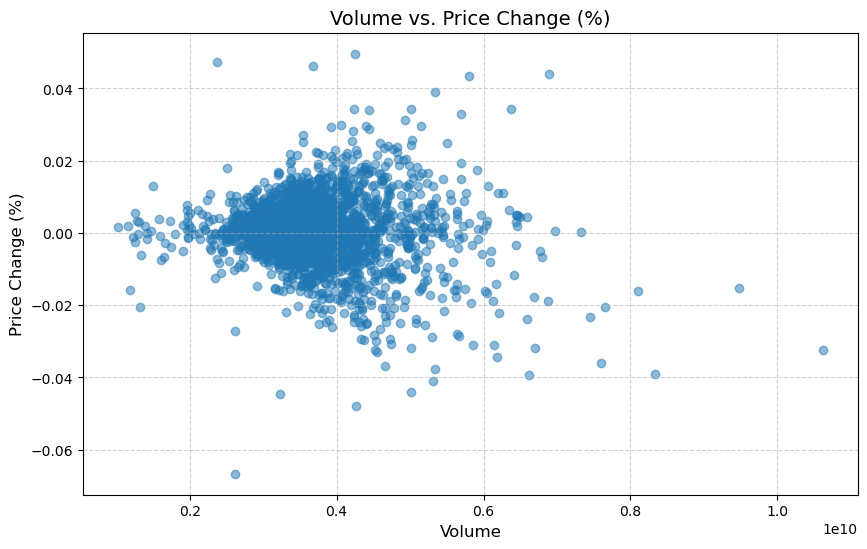

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(index_data["Volume"], index_data["Price_Change"], alpha=0.5)
plt.title("Volume vs. Price Change (%)", fontsize=14)
plt.xlabel("Volume", fontsize=12)
plt.ylabel("Price Change (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

High Volume and High Price Change:

Outliers on the top-right or bottom-right of the graph (large volume with significant price changes) could indicate market-moving events.
Market Stability:

The concentration of points near the origin suggests that most days see stable prices and moderate trading activity.
Event-Driven Volatility:

The outliers (large price changes or unusually high volumes) may help you identify event-driven periods that warrant further investigation.


In [26]:
index_datas = pd.read_csv('sp500_index_volume.csv')
        
check_stationarity(index_datas['Volume'].values)
check_stationarity(index_datas['Price_Change'].values)

ADF Statistic: -5.342899295293488
p-value: 4.4596920599956524e-06
The series is stationary.
ADF Statistic: -11.461060185389677
p-value: 5.553316149027219e-21
The series is stationary.


In [27]:
X,y,feature_scaler, target_scaler = window_generator(ticker_data,ticker_data.columns ,['Price_Change_AAPL'],60,3,1)

In [28]:
X.shape, y.shape

((2454, 60, 1), (2454, 3, 1))

In [29]:
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    Input(shape = (60, 1)),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),    
    Dense(3, activation='linear')  # Match the output shape (20, 1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,411 (114.89 KB)

 Trainable params: 29,411 (114.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# Train the model
history = model.fit(
    X, y,
    epochs=300,           # Number of training epochs
    batch_size=32,       # Batch size
    validation_split=0.2 # Use 20% of the data for validation
)


Epoch 1/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.2455 - mape: 155441.4219 - val_loss: 0.0170 - val_mape: 18.6810
Epoch 2/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0134 - mape: 455605.1562 - val_loss: 0.0123 - val_mape: 15.6994
Epoch 3/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0075 - mape: 81398.9766 - val_loss: 0.0070 - val_mape: 11.3776
Epoch 4/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0056 - mape: 118949.4766 - val_loss: 0.0070 - val_mape: 11.3658
Epoch 5/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0058 - mape: 181938.6250 - val_loss: 0.0071 - val_mape: 11.3989
Epoch 6/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0061 - mape: 432259.2812 - val_loss: 0.0069 - val_mape: 11.3849
Epoch 7/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0061 - mape: 284587.4688 - val_loss: 0.0069 - val_mape: 11.3128
Epoch 8/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0061 - mape: 437275.1250 - val_loss: 0.0069 - val_mape: 1

KeyboardInterrupt: 

In [ ]:
print("Input shape (X):", X.shape)  # Expected: (813, 60, 1)
print("Target shape (y):", y.shape) # Expected: (813, 20, 1)

In [ ]:
plot_training_history(history)

13165603570.539394
13487694670.173344
18939471939.614983
19478347798.557045
16631861559.59963
19051025327.741337
19792350225.06224
18222302013.53769
15373411909.259827
17298142836.25203
17579778996.21701
17740846284.64501
19008911512.09298
17258003489.32636
15169676431.765
16933178607.046162
17701518678.908424
17302655482.8441
18667681005.489773
17972068012.573875
16846266277.039854
16272686330.160406
15396860790.864012
16695120431.680756
16460054185.78101
17605600628.491146
17773965091.295605
16022978432.28367
18120434154.31747
16882551945.191757
18035682771.71324
18811488461.149307
18571517610.24801
17794001533.67701
18238372293.969013
22808381127.10925
18507149463.839085
15808986033.255783
19279844946.415512
18137575674.72014
20010147653.01296
19730921657.42812
17687347500.58639
18547754701.57359
19568419916.2486
19553189154.96135
19074578869.853386
19054673765.2054
14561545877.899214
19489296444.755875
19583658584.02732
21856101713.98814
14887763500.63488
13656887015.199585
2034069

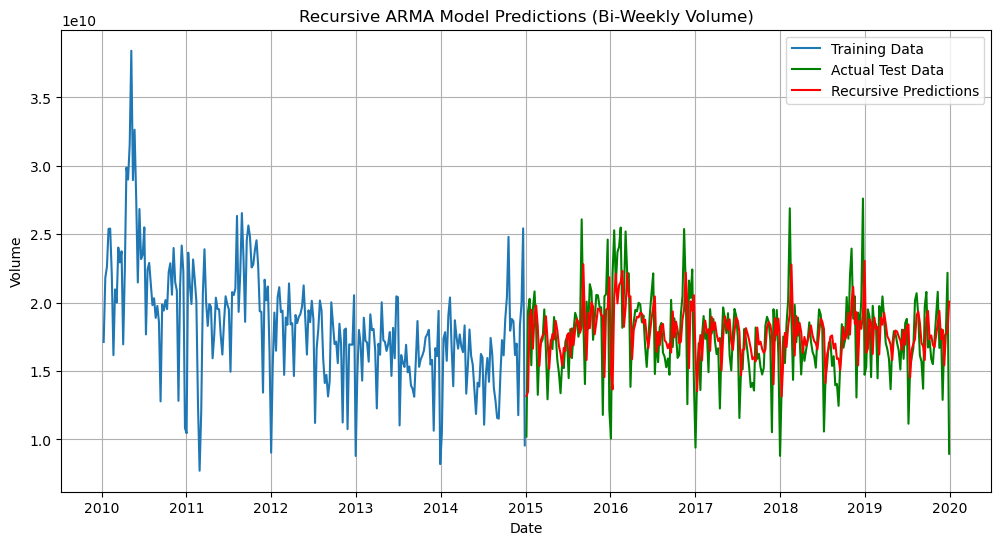

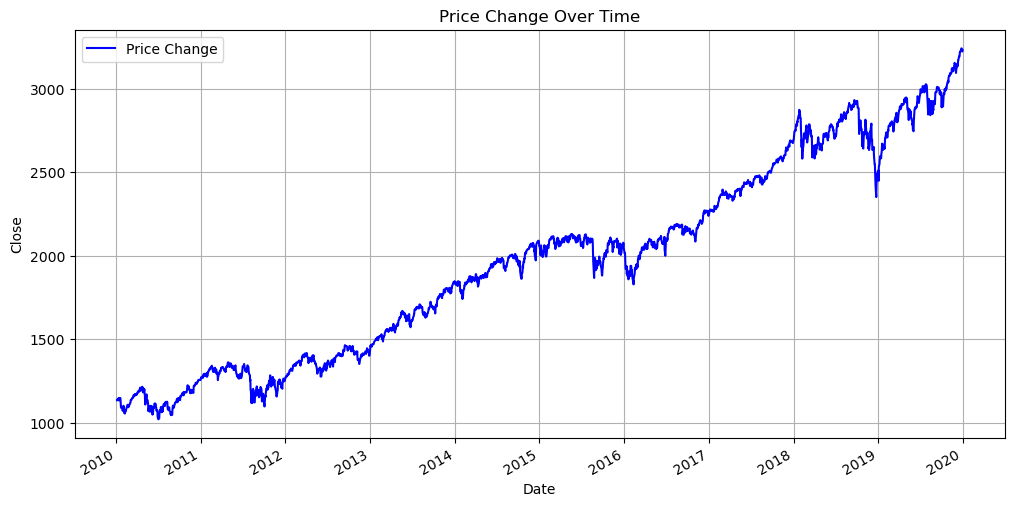

In [60]:
# Load the dataset
file_path = 'sp500_index_volume.csv'
index_volume = pd.read_csv(file_path)

# Convert the 'Date' column to datetime and set it as the index
index_volume['Date'] = pd.to_datetime(index_volume['Date'])
index_volume.set_index('Date', inplace=True)

# Resample the data to bi-weekly frequency (sum the volume for bi-weekly intervals)
biweekly_data = index_volume['Volume'].resample('1W').sum()

# Split into training and testing datasets
train_data = biweekly_data['2010-01-01':'2015-01-01']  # Training period
test_data = biweekly_data['2015-01-01':'2019-12-31']  # Testing period

# Step 1: Fit ARMA model once using the training data
fixed_order = (1, 0, 0)  # Predefine an order or find it from an initial grid search
initial_model = ARIMA(train_data, order=fixed_order)
fitted_model = initial_model.fit()

# Step 2: Use recursive forecasting for the test period
predictions_recursive = []
train_data_dynamic = train_data.copy()

for i in range(len(test_data)):
    forecast = fitted_model.get_forecast(steps=1)
    predicted_value = forecast.predicted_mean.iloc[0]
    print(predicted_value)
    predictions_recursive.append(predicted_value)

    # Update training data with the actual value from the test set
    new_data = test_data.iloc[i:i+1]
    train_data_dynamic = pd.concat([train_data_dynamic, new_data])

    # Refit the model using the updated training data
    fitted_model = ARIMA(train_data_dynamic, order=fixed_order).fit()

# Convert predictions to a pandas Series
predictions_recursive = pd.Series(predictions_recursive, index=test_data.index)


# Evaluate predictions
mse_recursive = mean_squared_error(test_data, predictions_recursive)
print(f"Mean Squared Error (Recursive ARMA): {mse_recursive}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Actual Test Data", color="green")
plt.plot(predictions_recursive, label="Recursive Predictions", color="red")
plt.title("Recursive ARMA Model Predictions (Bi-Weekly Volume)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
index_volume['Close'].plot(title="Price Change Over Time", color='blue', label='Price Change')
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
predictions_recursive.pct_change()


Date
2015-01-04         NaN
2015-01-11    0.024465
2015-01-18    0.404204
2015-01-25    0.028453
2015-02-01   -0.146136
                ...   
2019-12-01    0.040182
2019-12-08   -0.145013
2019-12-15    0.150680
2019-12-22    0.007385
2019-12-29    0.124427
Freq: W-SUN, Length: 261, dtype: float64

In [84]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU

model = Sequential([
    Input(shape=(60, 6)),  # Adjusted to match the input data shape
    LSTM(64, return_sequences=True),
    LeakyReLU(0.2),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    LeakyReLU(0.2),
    RepeatVector(14),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(3, activation='linear'))  # Outputs 10 features per time step
])
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 64)            18176     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 64)            0         
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 14, 32)            0         
 tor)                                                            
                                                      

In [85]:
ticker_data.columns.to_list()

# Example column names
columns = ticker_data.columns.to_list()

# Extract unique tickers from column names
tickers = list(set(col.split('_')[1] for col in columns))

random_tickers = random.sample(tickers, 3)

X_columns = [f"Volume_{ticker}" for ticker in random_tickers] + [f"Price_Change_{ticker}" for ticker in random_tickers]
y_columns = [f"Price_Change_{ticker}" for ticker in random_tickers]

X, y , feature_scaler, target_scaler = window_generator(ticker_data, X_columns, y_columns, 60, 14, 1)

In [94]:
from keras.src.callbacks import Callback


class ValidationLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_mae = logs.get('val_mae', 'N/A')  # Check if 'val_mae' exists in logs
        print(f"Validation Interval: Epoch {epoch + 1}, Validation MAE: {val_mae}")
        

history = model.fit(
    X,
    y,
    validation_split=(0.2),  # Pass both validation inputs and targets
    epochs=30,
    verbose=0,
    callbacks=[ValidationLogger()]
)

Validation Interval: Epoch 1, Validation MAE: N/A
Validation Interval: Epoch 2, Validation MAE: N/A
Validation Interval: Epoch 3, Validation MAE: N/A
Validation Interval: Epoch 4, Validation MAE: N/A
Validation Interval: Epoch 5, Validation MAE: N/A
Validation Interval: Epoch 6, Validation MAE: N/A
Validation Interval: Epoch 7, Validation MAE: N/A
Validation Interval: Epoch 8, Validation MAE: N/A
Validation Interval: Epoch 9, Validation MAE: N/A
Validation Interval: Epoch 10, Validation MAE: N/A
Validation Interval: Epoch 11, Validation MAE: N/A
Validation Interval: Epoch 12, Validation MAE: N/A
Validation Interval: Epoch 13, Validation MAE: N/A
Validation Interval: Epoch 14, Validation MAE: N/A
Validation Interval: Epoch 15, Validation MAE: N/A
Validation Interval: Epoch 16, Validation MAE: N/A
Validation Interval: Epoch 17, Validation MAE: N/A
Validation Interval: Epoch 18, Validation MAE: N/A
Validation Interval: Epoch 19, Validation MAE: N/A
Validation Interval: Epoch 20, Validatio